# pvsystem tutorial

This tutorial explores the ``pvlib.pvsystem`` module. The module has functions for importing PV module and inverter data and functions for modeling module and inverter performance.

1. [systemdef](#systemdef)
2. [Angle of Incidence Modifiers](#Angle-of-Incidence-Modifiers)
2. [Sandia Cell Temp correction](#Sandia-Cell-Temp-correction)
2. [Sandia Inverter Model](#snlinverter)
2. [Sandia Array Performance Model](#SAPM)
    1. [SAPM IV curves](#SAPM-IV-curves)
2. [DeSoto Model](#desoto)
2. [Single Diode Model](#Single-diode-model)

This tutorial has been tested against the following package versions:
* pvlib 0.4.5
* Python 3.6.2
* IPython 6.0
* Pandas 0.20.1

It should work with other Python and Pandas versions. It requires pvlib >= 0.4.0 and IPython >= 3.0.

Authors:
* Will Holmgren (@wholmgren), University of Arizona. 2015, March 2016, November 2016, May 2017.

In [1]:
# built-in python modules
import os
import inspect
import datetime

# scientific python add-ons
import numpy as np
import pandas as pd

# plotting stuff
# first line makes the plots appear in the notebook
%matplotlib inline 
import matplotlib.pyplot as plt
# seaborn makes your plots look better
try:
    import seaborn as sns
    sns.set(rc={"figure.figsize": (12, 6)})
except ImportError:
    print('We suggest you install seaborn using conda or pip and rerun this cell')

# finally, we import the pvlib library
import pvlib

In [2]:
import pvlib
from pvlib import pvsystem

### systemdef

``pvlib`` can import TMY2 and TMY3 data. Here, we import the example files.

In [3]:
pvlib_abspath = os.path.dirname(os.path.abspath(inspect.getfile(pvlib)))

tmy3_data, tmy3_metadata = pvlib.tmy.readtmy3(os.path.join(pvlib_abspath, 'data', '703165TY.csv'))
tmy2_data, tmy2_metadata = pvlib.tmy.readtmy2(os.path.join(pvlib_abspath, 'data', '12839.tm2'))

In [4]:
pvlib.pvsystem.systemdef(tmy3_metadata, 0, 0, .1, 5, 5)

{'albedo': 0.1,
 'altitude': 7.0,
 'latitude': 55.317,
 'longitude': -160.517,
 'modules_per_string': 5,
 'name': '"SAND POINT"',
 'strings_per_inverter': 5,
 'surface_azimuth': 0,
 'surface_tilt': 0,
 'tz': -9.0}

In [5]:
pvlib.pvsystem.systemdef(tmy2_metadata, 0, 0, .1, 5, 5)

{'albedo': 0.1,
 'altitude': 2.0,
 'latitude': 25.8,
 'longitude': -80.26666666666667,
 'modules_per_string': 5,
 'name': 'MIAMI',
 'strings_per_inverter': 5,
 'surface_azimuth': 0,
 'surface_tilt': 0,
 'tz': -5}

### Angle of Incidence Modifiers

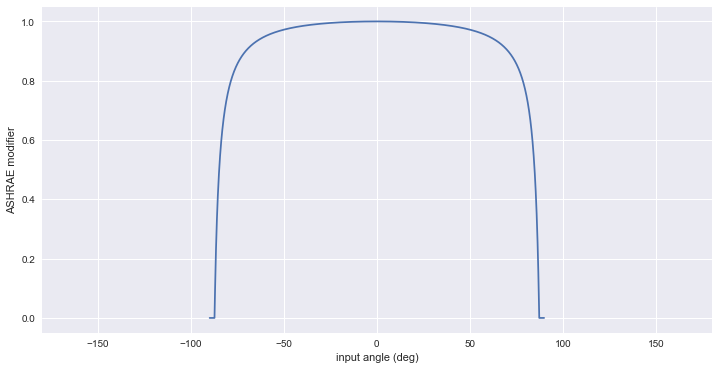

In [6]:
angles = np.linspace(-180,180,3601)
ashraeiam = pd.Series(pvsystem.ashraeiam(angles, .05), index=angles)

ashraeiam.plot()
plt.ylabel('ASHRAE modifier')
plt.xlabel('input angle (deg)')

/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/pvsystem.py:820: RuntimeWarning: invalid value encountered in true_divide
  ((tools.sind(thetar_deg + aoi)) ** 2) +
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/pvsystem.py:822: RuntimeWarning: invalid value encountered in true_divide
  ((tools.tand(thetar_deg + aoi)) ** 2))))))
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/pvsystem.py:836: RuntimeWarning: invalid value encountered in less
  iam = np.where((np.abs(aoi) >= 90) | (iam < 0), np.nan, iam)


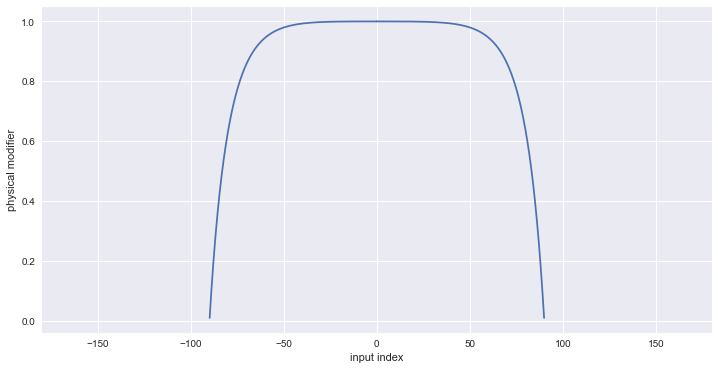

In [7]:
angles = np.linspace(-180,180,3601)
physicaliam = pd.Series(pvsystem.physicaliam(angles), index=angles)

physicaliam.plot()
plt.ylabel('physical modifier')
plt.xlabel('input index')

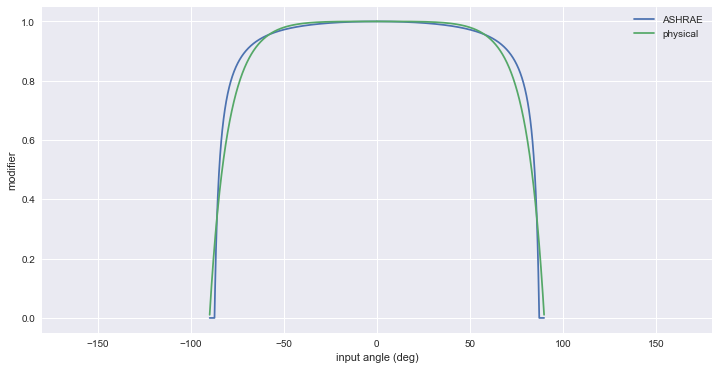

In [8]:
plt.figure()
ashraeiam.plot(label='ASHRAE')
physicaliam.plot(label='physical')
plt.ylabel('modifier')
plt.xlabel('input angle (deg)')
plt.legend()

### Sandia Cell Temp correction

PV system efficiency can vary by up to 0.5% per degree C, so it's important to accurately model cell and module temperature. The ``sapm_celltemp`` function uses plane of array irradiance, ambient temperature, wind speed, and module and racking type to calculate cell and module temperatures. From King et. al. (2004):

$$T_m = E e^{a+b*WS} + T_a$$

$$T_c = T_m + \frac{E}{E_0} \Delta T$$

The $a$, $b$, and $\Delta T$ parameters depend on the module and racking type. The default parameter set is ``open_rack_cell_glassback``.

``sapm_celltemp`` works with either scalar or vector inputs, but always returns a pandas DataFrame.

In [9]:
# scalar inputs
pvsystem.sapm_celltemp(900, 5, 20) # irrad, wind, temp

,temp_cell,temp_module
0,43.509191,40.809191


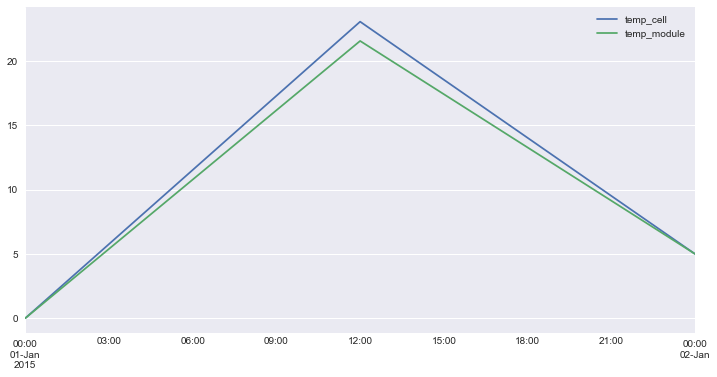

In [10]:
# vector inputs
times = pd.DatetimeIndex(start='2015-01-01', end='2015-01-02', freq='12H')
temps = pd.Series([0, 10, 5], index=times)
irrads = pd.Series([0, 500, 0], index=times)
winds = pd.Series([10, 5, 0], index=times)

pvtemps = pvsystem.sapm_celltemp(irrads, winds, temps)
pvtemps.plot()

Cell and module temperature as a function of wind speed.

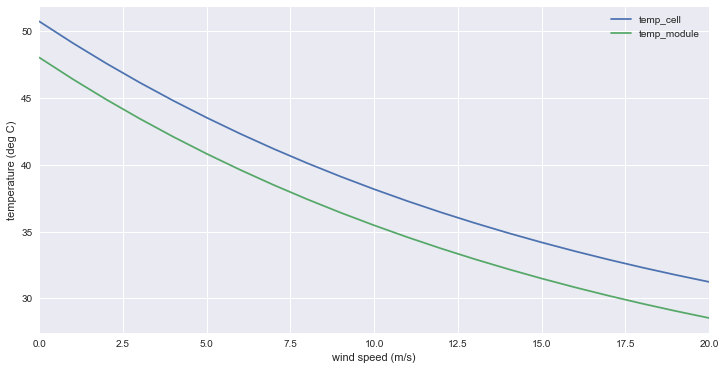

In [11]:
wind = np.linspace(0,20,21)
temps = pd.DataFrame(pvsystem.sapm_celltemp(900, wind, 20), index=wind)

temps.plot()
plt.legend()
plt.xlabel('wind speed (m/s)')
plt.ylabel('temperature (deg C)')

Cell and module temperature as a function of ambient temperature.

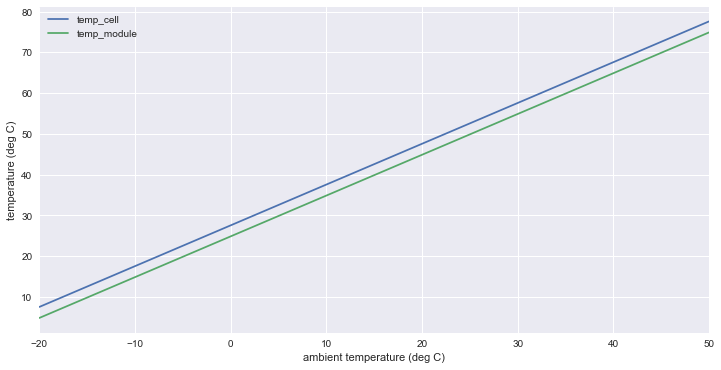

In [12]:
atemp = np.linspace(-20,50,71)
temps = pvsystem.sapm_celltemp(900, 2, atemp).set_index(atemp)

temps.plot()
plt.legend()
plt.xlabel('ambient temperature (deg C)')
plt.ylabel('temperature (deg C)')

Cell and module temperature as a function of incident irradiance.

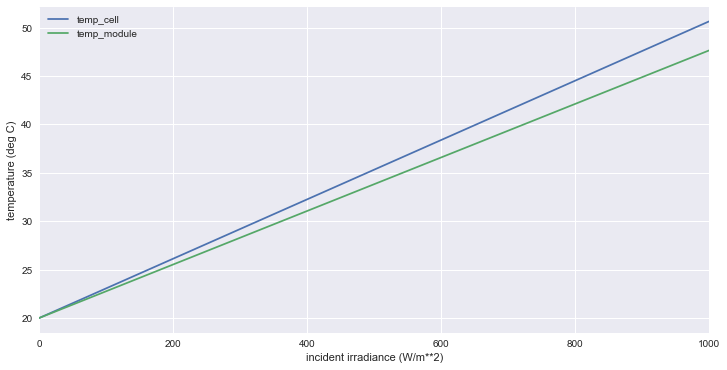

In [13]:
irrad = np.linspace(0,1000,101)
temps = pvsystem.sapm_celltemp(irrad, 2, 20).set_index(irrad)

temps.plot()
plt.legend()
plt.xlabel('incident irradiance (W/m**2)')
plt.ylabel('temperature (deg C)')

Cell and module temperature for different module and racking types.

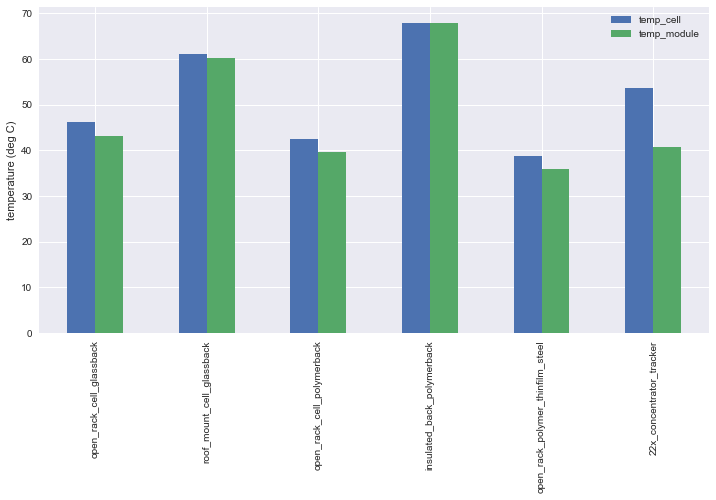

In [14]:
models = ['open_rack_cell_glassback',
          'roof_mount_cell_glassback',
          'open_rack_cell_polymerback',
          'insulated_back_polymerback',
          'open_rack_polymer_thinfilm_steel',
          '22x_concentrator_tracker']

temps = pd.DataFrame(index=['temp_cell','temp_module'])

for model in models:
    temps[model] = pd.Series(pvsystem.sapm_celltemp(1000, 5, 20, model=model).iloc[0])

temps.T.plot(kind='bar') # try removing the transpose operation and replotting
plt.legend()
plt.ylabel('temperature (deg C)')

### snlinverter

In [15]:
inverters = pvsystem.retrieve_sam('sandiainverter')
inverters

,ABB__MICRO_0_25_I_OUTD_US_208_208V__CEC_2014_,ABB__MICRO_0_25_I_OUTD_US_240_240V__CEC_2014_,ABB__MICRO_0_3HV_I_OUTD_US_208_208V__CEC_2014_,ABB__MICRO_0_3HV_I_OUTD_US_240_240V__CEC_2014_,ABB__MICRO_0_3_I_OUTD_US_208_208V__CEC_2014_,ABB__MICRO_0_3_I_OUTD_US_240_240V__CEC_2014_,ABB__PVI_3_0_OUTD_S_US_Z_M_A__208_V__208V__CEC_2014_,ABB__PVI_3_0_OUTD_S_US_Z_M_A__240_V__240V__CEC_2014_,ABB__PVI_3_0_OUTD_S_US_Z_M_A__277_V__277V__CEC_2014_,ABB__PVI_3_6_OUTD_S_US_Z_M__208_V__208V__CEC_2014_,...,Yes!_Solar_Inc___ES5000__240V__240V__CEC_2009_,Yes!_Solar_Inc___ES5300__208V__208V__CEC_2009_,Yes!_Solar_Inc___ES5300__240V__240V__CEC_2009_,Zhejiang_Yuhui_Solar_Energy_Source__Replus_250A_240V__CEC_2012_,Zhejiang_Yuhui_Solar_Energy_Source__Replus_250B_208V__CEC_2012_,Zigor__Sunzet_2_TL_US_240V__CEC_2011_,Zigor__Sunzet_3_TL_US_240V__CEC_2011_,Zigor__Sunzet_4_TL_US_240V__CEC_2011_,Zigor__Sunzet_5_TL_US_240V__CEC_2011_,Zigor__SUNZET4_USA_240V__CEC_2011_
Vac,208.000000,240.000000,208.000000,240.000000,208.000000,240.000000,208.000000,240.000000,277.000000,208.000000,...,240.000000,208.000000,240.000000,2.400000e+02,208.000000,240.000000,240.000000,240.000000,240.000000,240.000000
Paco,250.000000,250.000000,300.000000,300.000000,300.000000,300.000000,3000.000000,3000.000000,3000.000000,3600.000000,...,4900.000000,4600.000000,5300.000000,2.251900e+02,213.830000,2110.000000,3180.000000,4160.000000,5240.000000,4030.000000
Pdco,259.522050,259.552697,312.523347,312.022059,311.714554,311.504961,3147.009528,3125.758222,3110.342942,3759.288140,...,5135.584132,4829.422409,5571.180956,2.348419e+02,225.563055,2191.825129,3313.675805,4342.409314,5495.829926,4267.477069
Vdco,40.242603,39.982246,45.259429,45.495009,40.227111,40.136095,313.429286,340.842937,389.986270,309.948254,...,275.000000,275.000000,274.900000,2.846843e+01,28.632617,399.207333,389.513254,388.562050,386.082539,302.851707
Pso,1.771614,1.931194,1.882620,1.928591,1.971053,1.991342,18.104122,19.866112,22.720135,24.202212,...,29.358943,26.071506,28.519033,1.646711e+00,1.845029,30.843703,31.265046,31.601704,32.450808,37.372766
C0,-0.000025,-0.000027,-0.000049,-0.000035,-0.000036,-0.000031,-0.000009,-0.000007,-0.000006,-0.000005,...,-0.000006,-0.000006,-0.000006,-3.860000e-07,-0.000121,-0.000004,-0.000006,-0.000004,-0.000005,-0.000009
C1,-0.000090,-0.000158,-0.000241,-0.000228,-0.000256,-0.000289,-0.000012,-0.000025,-0.000044,0.000002,...,0.000020,0.000024,0.000019,-3.580000e-04,-0.000533,-0.000077,-0.000095,-0.000079,-0.000097,-0.000029
C2,0.000669,0.001480,0.000975,-0.000224,-0.000833,-0.002110,0.001620,0.001050,0.000036,0.001730,...,0.001870,0.002620,0.001630,-1.350000e-02,0.025900,0.000502,0.000261,0.000213,-0.000251,0.002150
C3,-0.018900,-0.034600,-0.027600,-0.039600,-0.039100,-0.049500,-0.000217,-0.000471,-0.001550,0.001140,...,-0.000276,0.000468,-0.000371,-3.350684e+01,-0.066800,-0.003260,-0.001960,-0.001870,-0.002340,-0.001900
Pnt,0.020000,0.050000,0.060000,0.060000,0.020000,0.050000,0.100000,0.100000,0.200000,0.100000,...,0.500000,0.500000,0.500000,1.700000e-01,0.170000,0.250000,0.250000,0.200000,0.200000,0.190000


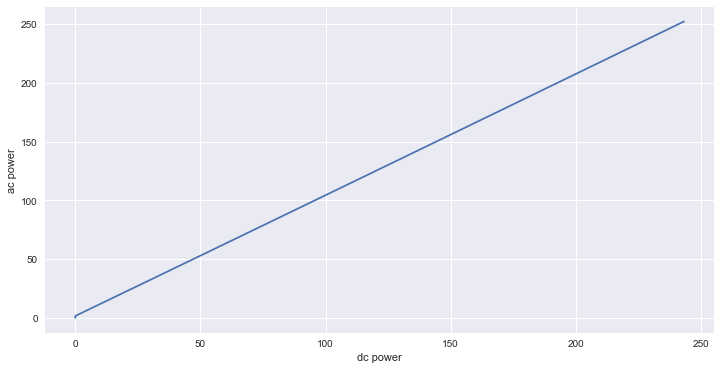

In [16]:
vdcs = pd.Series(np.linspace(0,50,51))
idcs = pd.Series(np.linspace(0,11,110))
pdcs = idcs * vdcs

pacs = pvsystem.snlinverter(vdcs, pdcs, inverters['ABB__MICRO_0_25_I_OUTD_US_208_208V__CEC_2014_'])
#pacs.plot()
plt.plot(pacs, pdcs)
plt.ylabel('ac power')
plt.xlabel('dc power')

Need to put more effort into describing this function.

### SAPM

The CEC module database.

In [17]:
cec_modules = pvsystem.retrieve_sam('cecmod')
cec_modules

,BEoptCA_Default_Module,Example_Module,1Soltech_1STH_215_P,1Soltech_1STH_220_P,1Soltech_1STH_225_P,1Soltech_1STH_230_P,1Soltech_1STH_235_WH,1Soltech_1STH_240_WH,1Soltech_1STH_245_WH,1Soltech_1STH_FRL_4H_245_M60_BLK,...,Zytech_Solar_ZT275P,Zytech_Solar_ZT280P,Zytech_Solar_ZT285P,Zytech_Solar_ZT290P,Zytech_Solar_ZT295P,Zytech_Solar_ZT300P,Zytech_Solar_ZT305P,Zytech_Solar_ZT310P,Zytech_Solar_ZT315P,Zytech_Solar_ZT320P
BIPV,Y,Y,N,N,N,N,N,N,N,N,...,N,N,N,N,N,N,N,N,N,N
Date,12/17/2008,4/28/2008,10/7/2010,10/4/2010,10/4/2010,10/4/2010,3/4/2010,3/4/2010,3/4/2010,1/14/2013,...,12/23/2014,12/23/2014,12/23/2014,12/23/2014,12/23/2014,12/23/2014,12/23/2014,12/23/2014,12/23/2014,12/23/2014
T_NOCT,65,65,47.4,47.4,47.4,47.4,49.9,49.9,49.9,48.3,...,46.4,46.4,46.4,46.4,46.4,46.4,46.4,46.4,46.4,46.4
A_c,0.67,0.67,1.567,1.567,1.567,1.567,1.635,1.635,1.635,1.668,...,1.931,1.931,1.931,1.931,1.931,1.931,1.931,1.931,1.931,1.931
N_s,18,18,60,60,60,60,60,60,60,60,...,72,72,72,72,72,72,72,72,72,72
I_sc_ref,7.5,7.5,7.84,7.97,8.09,8.18,8.54,8.58,8.62,8.81,...,8.31,8.4,8.48,8.55,8.64,8.71,8.87,8.9,9.01,9.12
V_oc_ref,10.4,10.4,36.3,36.6,36.9,37.1,37,37.1,37.2,38.3,...,45.1,45.25,45.43,45.59,45.75,45.96,46.12,46.28,46.44,46.6
I_mp_ref,6.6,6.6,7.35,7.47,7.58,7.65,8.02,8.07,8.1,8.06,...,7.76,7.87,7.97,8.07,8.16,8.26,8.36,8.46,8.56,8.66
V_mp_ref,8.4,8.4,29,29.3,29.6,29.9,29.3,29.7,30.2,30.2,...,35.44,35.62,35.8,35.94,36.16,36.32,36.49,36.66,36.81,37
alpha_sc,0.003,0.003,0.007997,0.008129,0.008252,0.008344,0.00743,0.007465,0.007499,0.006167,...,0.004014,0.004057,0.004096,0.00413,0.004173,0.004207,0.004284,0.004299,0.004352,0.004405


In [18]:
cecmodule = cec_modules.Example_Module 
cecmodule

BIPV                   Y
Date           4/28/2008
T_NOCT                65
A_c                 0.67
N_s                   18
I_sc_ref             7.5
V_oc_ref            10.4
I_mp_ref             6.6
V_mp_ref             8.4
alpha_sc           0.003
beta_oc            -0.04
a_ref              0.473
I_L_ref            7.545
I_o_ref        1.943e-09
R_s                0.094
R_sh_ref           15.72
Adjust              10.6
gamma_r             -0.5
Version            MM105
PTC                 48.9
Technology    Multi-c-Si
Name: Example_Module, dtype: object

The Sandia module database.

In [19]:
sandia_modules = pvsystem.retrieve_sam(name='SandiaMod')
sandia_modules

,Advent_Solar_AS160___2006_,Advent_Solar_Ventura_210___2008_,Advent_Solar_Ventura_215___2009_,Aleo_S03_160__2007__E__,Aleo_S03_165__2007__E__,Aleo_S16_165__2007__E__,Aleo_S16_170__2007__E__,Aleo_S16_175__2007__E__,Aleo_S16_180__2007__E__,Aleo_S16_185__2007__E__,...,Panasonic_VBHN235SA06B__2013_,Trina_TSM_240PA05__2013_,Hanwha_HSL60P6_PA_4_250T__2013_,Suniva_OPT300_72_4_100__2013_,Canadian_Solar_CS6X_300M__2013_,LG_LG290N1C_G3__2013_,Sharp_NDQ235F4__2013_,Solar_Frontier_SF_160S__2013_,SolarWorld_Sunmodule_250_Poly__2013_,Silevo_Triex_U300_Black__2014_
Vintage,2006,2008,2009,2007 (E),2007 (E),2007 (E),2007 (E),2007 (E),2007 (E),2007 (E),...,2013,2013,2013,2013,2013,2013,2013,2013,2013,2014
Area,1.312,1.646,1.646,1.28,1.28,1.378,1.378,1.378,1.378,1.378,...,1.26,1.63,1.65,1.93,1.91,1.64,1.56,1.22,1.68,1.68
Material,mc-Si,mc-Si,mc-Si,c-Si,c-Si,mc-Si,mc-Si,mc-Si,mc-Si,mc-Si,...,a-Si / mono-Si,mc-Si,mc-Si,c-Si,c-Si,c-Si,mc-Si,CIS,mc-Si,c-Si
Cells_in_Series,72,60,60,72,72,50,50,50,50,50,...,72,60,60,72,72,60,60,172,60,96
Parallel_Strings,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Isco,5.564,8.34,8.49,5.1,5.2,7.9,7.95,8.1,8.15,8.2,...,5.8738,8.8449,8.5935,8.5753,8.6388,9.8525,8.6739,2.0259,8.3768,5.771
Voco,42.832,35.31,35.92,43.5,43.6,30,30.1,30.2,30.3,30.5,...,52.0042,36.8926,36.8075,44.2921,43.5918,39.6117,36.8276,112.505,36.3806,68.5983
Impo,5.028,7.49,7.74,4.55,4.65,7.08,7.23,7.38,7.53,7.67,...,5.5383,8.2955,8.0822,7.963,8.1359,9.2473,8.1243,1.8356,7.6921,5.383
Vmpo,32.41,27.61,27.92,35.6,35.8,23.3,23.5,23.7,23.9,24.1,...,43.1204,29.066,29.2011,35.0837,34.9531,31.2921,29.1988,86.6752,28.348,55.4547
Aisc,0.000537,0.00077,0.00082,0.0003,0.0003,0.0008,0.0008,0.0008,0.0008,0.0008,...,0.0005,0.0004,0.0004,0.0006,0.0005,0.0002,0.0006,0.0001,0.0006,0.0003


In [20]:
sandia_module = sandia_modules.Canadian_Solar_CS5P_220M___2009_
sandia_module

Vintage                                                          2009
Area                                                            1.701
Material                                                         c-Si
Cells_in_Series                                                    96
Parallel_Strings                                                    1
Isco                                                          5.09115
Voco                                                          59.2608
Impo                                                          4.54629
Vmpo                                                          48.3156
Aisc                                                         0.000397
Aimp                                                         0.000181
C0                                                            1.01284
C1                                                         -0.0128398
Bvoco                                                        -0.21696
Mbvoc               

Generate some irradiance data for modeling.

In [21]:
from pvlib import clearsky
from pvlib import irradiance
from pvlib import atmosphere
from pvlib.location import Location

tus = Location(32.2, -111, 'US/Arizona', 700, 'Tucson')

times_loc = pd.date_range(start=datetime.datetime(2014,4,1), end=datetime.datetime(2014,4,2), freq='30s', tz=tus.tz)
solpos = pvlib.solarposition.get_solarposition(times_loc, tus.latitude, tus.longitude)
dni_extra = pvlib.irradiance.extraradiation(times_loc)
airmass = pvlib.atmosphere.relativeairmass(solpos['apparent_zenith'])
pressure = pvlib.atmosphere.alt2pres(tus.altitude)
am_abs = pvlib.atmosphere.absoluteairmass(airmass, pressure)
cs = tus.get_clearsky(times_loc)

surface_tilt = tus.latitude
surface_azimuth = 180  # pointing south

aoi = pvlib.irradiance.aoi(surface_tilt, surface_azimuth,
                           solpos['apparent_zenith'], solpos['azimuth'])
total_irrad = pvlib.irradiance.total_irrad(surface_tilt,
                                           surface_azimuth,
                                           solpos['apparent_zenith'],
                                           solpos['azimuth'],
                                           cs['dni'], cs['ghi'], cs['dhi'],
                                           dni_extra=dni_extra,
                                           model='haydavies')

Now we can run the module parameters and the irradiance data through the SAPM functions.

/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/pvsystem.py:1303: RuntimeWarning: divide by zero encountered in log
  module['Voco'] + module['Cells_in_Series']*delta*np.log(Ee) +
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/pvsystem.py:1309: RuntimeWarning: divide by zero encountered in log
  module['C3']*module['Cells_in_Series']*((delta*np.log(Ee)) ** 2) +


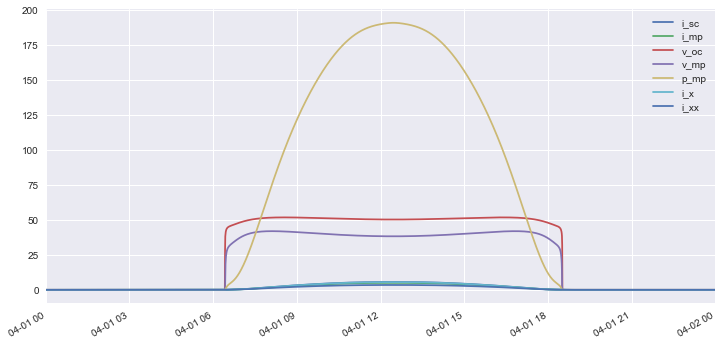

In [22]:
module = sandia_module

# a sunny, calm, and hot day in the desert
temps = pvsystem.sapm_celltemp(total_irrad['poa_global'], 0, 30)

effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
    total_irrad['poa_direct'], total_irrad['poa_diffuse'],
    am_abs, aoi, module)

sapm_1 = pvlib.pvsystem.sapm(effective_irradiance, temps['temp_cell'], module)

sapm_1.plot()

In [23]:
def plot_sapm(sapm_data, effective_irradiance):
    """
    Makes a nice figure with the SAPM data.
    
    Parameters
    ----------
    sapm_data : DataFrame
        The output of ``pvsystem.sapm``
    """
    fig, axes = plt.subplots(2, 3, figsize=(16,10), sharex=False, sharey=False, squeeze=False)
    plt.subplots_adjust(wspace=.2, hspace=.3)

    ax = axes[0,0]
    sapm_data.filter(like='i_').plot(ax=ax)
    ax.set_ylabel('Current (A)')

    ax = axes[0,1]
    sapm_data.filter(like='v_').plot(ax=ax)
    ax.set_ylabel('Voltage (V)')

    ax = axes[0,2]
    sapm_data.filter(like='p_').plot(ax=ax)
    ax.set_ylabel('Power (W)')

    ax = axes[1,0]
    [ax.plot(effective_irradiance, current, label=name) for name, current in
     sapm_data.filter(like='i_').iteritems()]
    ax.set_ylabel('Current (A)')
    ax.set_xlabel('Effective Irradiance')
    ax.legend(loc=2)

    ax = axes[1,1]
    [ax.plot(effective_irradiance, voltage, label=name) for name, voltage in
     sapm_data.filter(like='v_').iteritems()]
    ax.set_ylabel('Voltage (V)')
    ax.set_xlabel('Effective Irradiance')
    ax.legend(loc=4)

    ax = axes[1,2]
    ax.plot(effective_irradiance, sapm_data['p_mp'], label='p_mp')
    ax.set_ylabel('Power (W)')
    ax.set_xlabel('Effective Irradiance')
    ax.legend(loc=2)

    # needed to show the time ticks
    for ax in axes.flatten():
        for tk in ax.get_xticklabels():
            tk.set_visible(True)

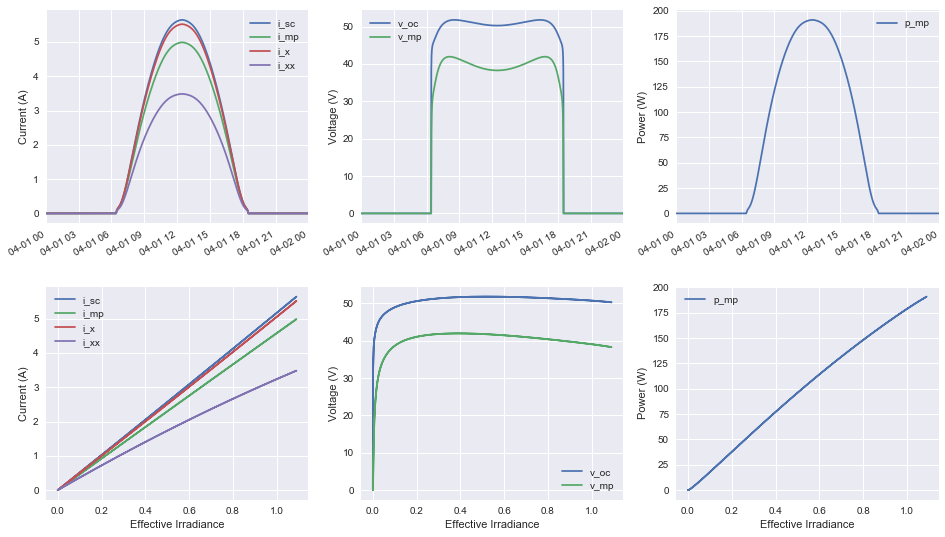

In [24]:
plot_sapm(sapm_1, effective_irradiance)

For comparison, here's the SAPM for a sunny, windy, cold version of the same day.

/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/pvsystem.py:1303: RuntimeWarning: divide by zero encountered in log
  module['Voco'] + module['Cells_in_Series']*delta*np.log(Ee) +
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/pvsystem.py:1309: RuntimeWarning: divide by zero encountered in log
  module['C3']*module['Cells_in_Series']*((delta*np.log(Ee)) ** 2) +


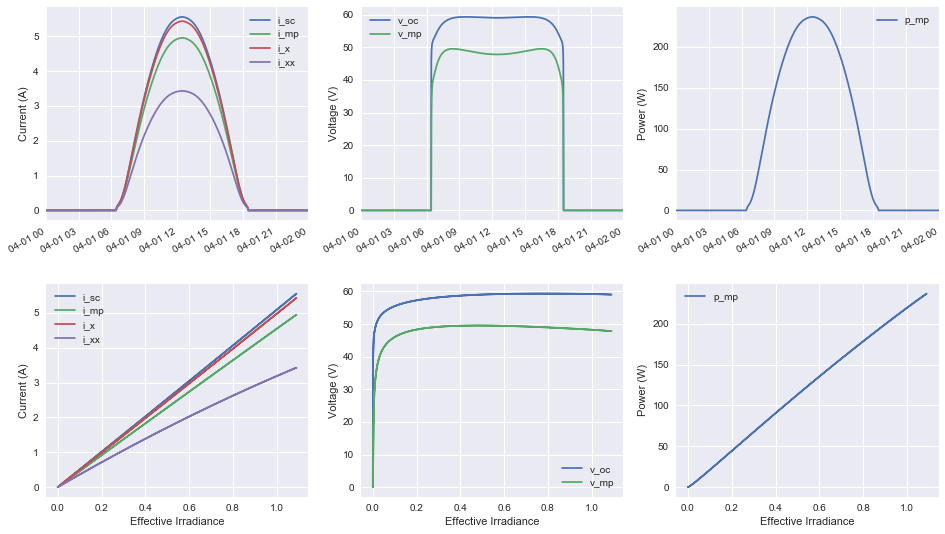

In [25]:
temps = pvsystem.sapm_celltemp(total_irrad['poa_global'], 10, 5)

sapm_2 = pvlib.pvsystem.sapm(effective_irradiance, temps['temp_cell'], module)

plot_sapm(sapm_2, effective_irradiance)

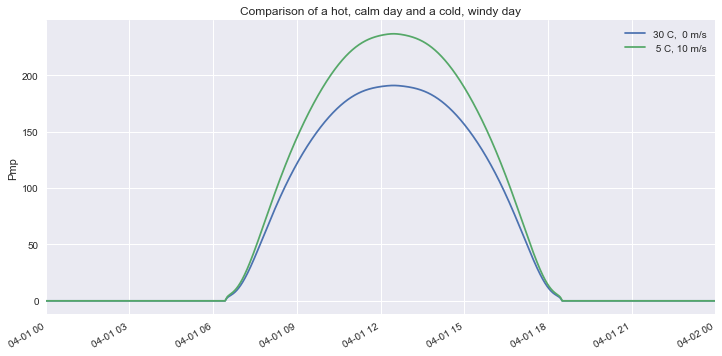

In [26]:
sapm_1['p_mp'].plot(label='30 C,  0 m/s')
sapm_2['p_mp'].plot(label=' 5 C, 10 m/s')
plt.legend()
plt.ylabel('Pmp')
plt.title('Comparison of a hot, calm day and a cold, windy day')

#### SAPM IV curves

The IV curve function only calculates the 5 points of the SAPM. We will add arbitrary points in a future release, but for now we just interpolate between the 5 SAPM points.

In [27]:
import warnings
warnings.simplefilter('ignore', np.RankWarning)

In [28]:
def sapm_to_ivframe(sapm_row):
    pnt = sapm_row

    ivframe = {'Isc': (pnt['i_sc'], 0),
              'Pmp': (pnt['i_mp'], pnt['v_mp']),
              'Ix': (pnt['i_x'], 0.5*pnt['v_oc']),
              'Ixx': (pnt['i_xx'], 0.5*(pnt['v_oc']+pnt['v_mp'])),
              'Voc': (0, pnt['v_oc'])}
    ivframe = pd.DataFrame(ivframe, index=['current', 'voltage']).T
    ivframe = ivframe.sort_values(by='voltage')
    
    return ivframe

def ivframe_to_ivcurve(ivframe, points=100):
    ivfit_coefs = np.polyfit(ivframe['voltage'], ivframe['current'], 30)
    fit_voltages = np.linspace(0, ivframe.loc['Voc', 'voltage'], points)
    fit_currents = np.polyval(ivfit_coefs, fit_voltages)
    
    return fit_voltages, fit_currents

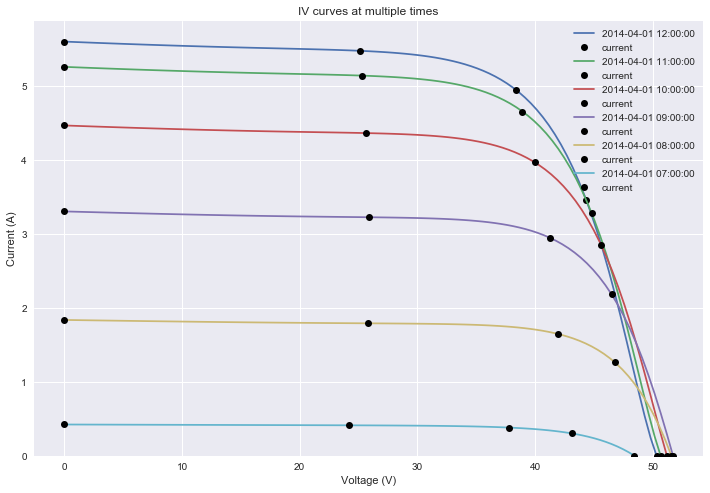

In [29]:
times = ['2014-04-01 07:00:00', '2014-04-01 08:00:00', '2014-04-01 09:00:00', 
         '2014-04-01 10:00:00', '2014-04-01 11:00:00', '2014-04-01 12:00:00']
times.reverse()

fig, ax = plt.subplots(1, 1, figsize=(12,8))

for time in times:
    ivframe = sapm_to_ivframe(sapm_1.loc[time])

    fit_voltages, fit_currents = ivframe_to_ivcurve(ivframe)

    ax.plot(fit_voltages, fit_currents, label=time)
    ax.plot(ivframe['voltage'], ivframe['current'], 'ko')
    
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Current (A)')
ax.set_ylim(0, None)
ax.set_title('IV curves at multiple times')
ax.legend()

### desoto

The same data run through the desoto model.

In [30]:
photocurrent, saturation_current, resistance_series, resistance_shunt, nNsVth = (
    pvsystem.calcparams_desoto(total_irrad['poa_global'],
                                 temp_cell=temps['temp_cell'],
                                 alpha_isc=cecmodule['alpha_sc'],
                                 module_parameters=cecmodule,
                                 EgRef=1.121,
                                 dEgdT=-0.0002677) )

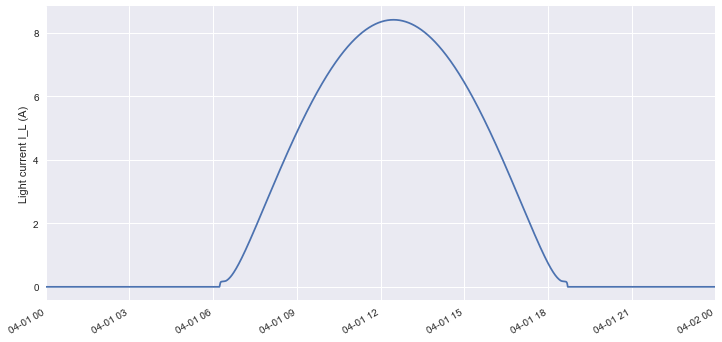

In [31]:
photocurrent.plot()
plt.ylabel('Light current I_L (A)')

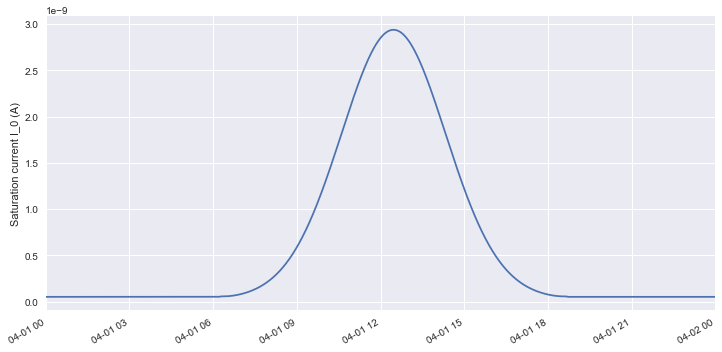

In [32]:
saturation_current.plot()
plt.ylabel('Saturation current I_0 (A)')

In [33]:
resistance_series

0.094

(0, 100)

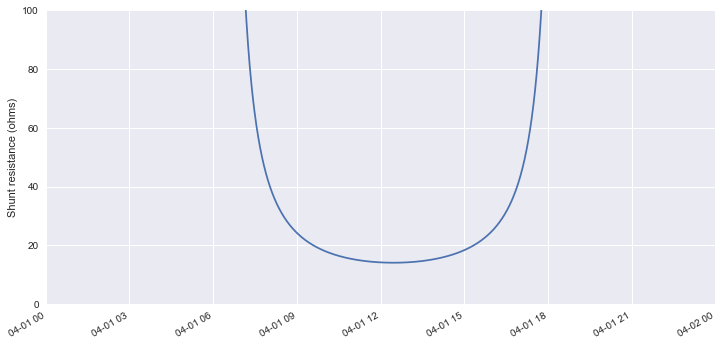

In [34]:
resistance_shunt.plot()
plt.ylabel('Shunt resistance (ohms)')
plt.ylim(0,100)

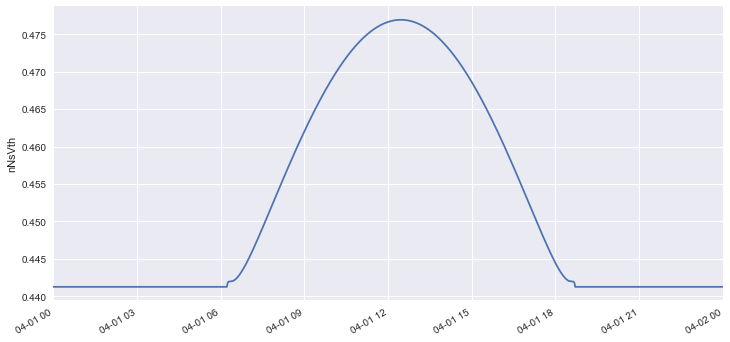

In [35]:
nNsVth.plot()
plt.ylabel('nNsVth')

### Single diode model

In [36]:
single_diode_out = pvsystem.singlediode(photocurrent, saturation_current,
                                        resistance_series, resistance_shunt, nNsVth)

/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/pvsystem.py:1943: RuntimeWarning: invalid value encountered in true_divide
  I = -V/(Rs + Rsh) - (nNsVth/Rs)*lambertwterm + Rsh*(IL + I0)/(Rs + Rsh)


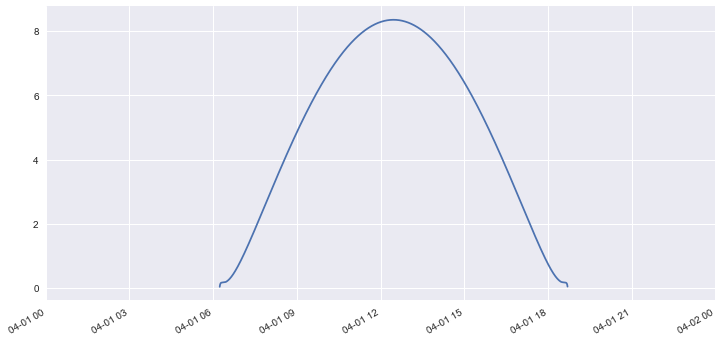

In [37]:
single_diode_out['i_sc'].plot()

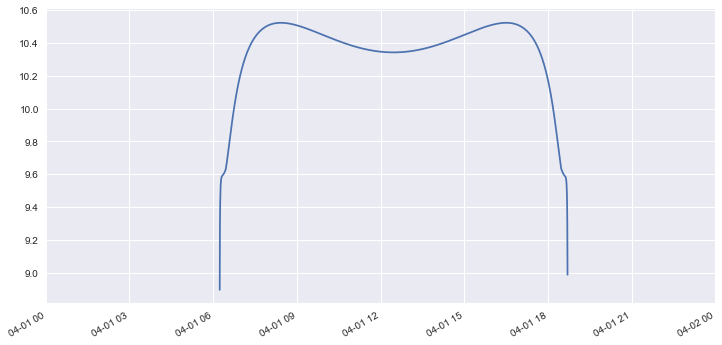

In [38]:
single_diode_out['v_oc'].plot()

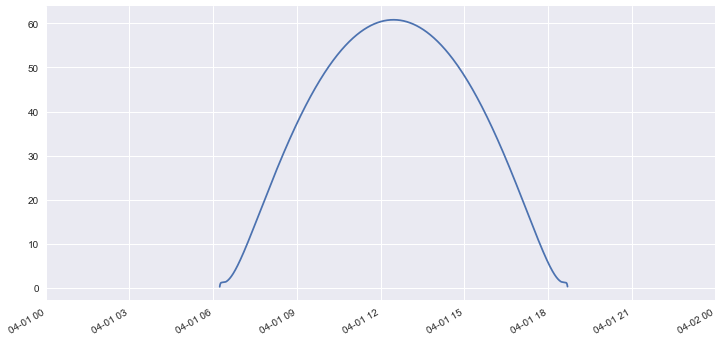

In [39]:
single_diode_out['p_mp'].plot()